In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import fashion_mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [15]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [6]:
def build_generator(z_dim):

    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

In [7]:
def build_discriminator(img_shape):

    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [8]:
def build_gan(generator, discriminator):

    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

In [10]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(z_dim)
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [18]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

        if (iteration + 1) % 500 == 0:
            sample_images(generator)
            iteration_checkpoints.append(iteration + 1)


In [19]:
z = np.random.normal(0, 1, (128, 100))
z.shape

(128, 100)

In [20]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    image_size = 28 
    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig,axes = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(8, 8))
    for i,ax in enumerate(axes.flatten()):
        img = gen_imgs[i,:]
        img = (img-img.min())/(img.max()-img.min())
        ax.imshow(img.reshape(image_size,image_size),cmap = 'gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()

4423680/4422102 [==============================] - 19s 4us/step



/home/shashikanth/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/shashikanth/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/shashikanth/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5 [D loss: 0.208636, acc.: 98.44%] [G loss: 0.858054]
10 [D loss: 0.063972, acc.: 99.61%] [G loss: 0.054663]
15 [D loss: 0.017639, acc.: 100.00%] [G loss: 0.062732]
20 [D loss: 0.024927, acc.: 100.00%] [G loss: 1.381977]
25 [D loss: 0.035377, acc.: 100.00%] [G loss: 0.167867]
30 [D loss: 0.003464, acc.: 100.00%] [G loss: 0.011877]
35 [D loss: 0.004631, acc.: 100.00%] [G loss: 0.024476]
40 [D loss: 0.002828, acc.: 100.00%] [G loss: 0.041747]
45 [D loss: 0.003604, acc.: 100.00%] [G loss: 0.037018]
50 [D loss: 0.003240, acc.: 100.00%] [G loss: 0.014566]
55 [D loss: 0.003224, acc.: 100.00%] [G loss: 0.005437]
60 [D loss: 0.002360, acc.: 100.00%] [G loss: 0.001971]
65 [D loss: 0.001318, acc.: 100.00%] [G loss: 0.001115]
70 [D loss: 0.001024, acc.: 100.00%] [G loss: 0.000635]
75 [D loss: 0.000715, acc.: 100.00%] [G loss: 0.000504]
80 [D loss: 0.000829, acc.: 100.00%] [G loss: 0.000291]
85 [D loss: 0.000341, acc.: 100.00%] [G loss: 0.000268]
90 [D loss: 0.000296, acc.: 100.00%] [G loss: 0.000

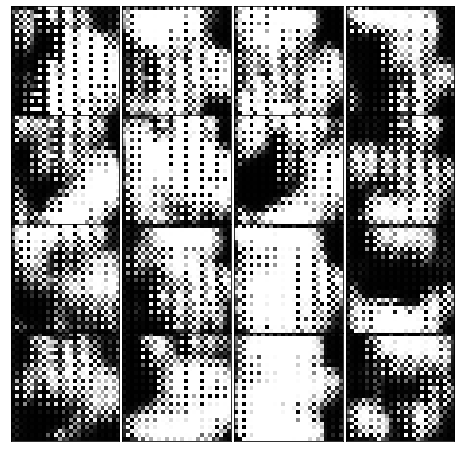

505 [D loss: 0.013819, acc.: 100.00%] [G loss: 0.037967]
510 [D loss: 0.004840, acc.: 100.00%] [G loss: 0.039171]
515 [D loss: 0.006931, acc.: 100.00%] [G loss: 0.098397]
520 [D loss: 0.007240, acc.: 100.00%] [G loss: 0.085555]
525 [D loss: 0.009600, acc.: 100.00%] [G loss: 0.062652]
530 [D loss: 0.003318, acc.: 100.00%] [G loss: 0.141692]
535 [D loss: 0.016275, acc.: 100.00%] [G loss: 2.522153]
540 [D loss: 0.972454, acc.: 59.38%] [G loss: 9.204350]
545 [D loss: 0.052049, acc.: 98.83%] [G loss: 4.106287]
550 [D loss: 0.008188, acc.: 100.00%] [G loss: 8.371246]
555 [D loss: 0.020254, acc.: 99.61%] [G loss: 10.575356]
560 [D loss: 0.002555, acc.: 100.00%] [G loss: 8.933055]
565 [D loss: 0.002158, acc.: 100.00%] [G loss: 5.376672]
570 [D loss: 0.018375, acc.: 99.61%] [G loss: 3.186564]
575 [D loss: 0.028824, acc.: 100.00%] [G loss: 4.176539]
580 [D loss: 0.056592, acc.: 98.05%] [G loss: 2.505237]
585 [D loss: 0.030745, acc.: 99.61%] [G loss: 3.635185]
590 [D loss: 0.042830, acc.: 99.22%]

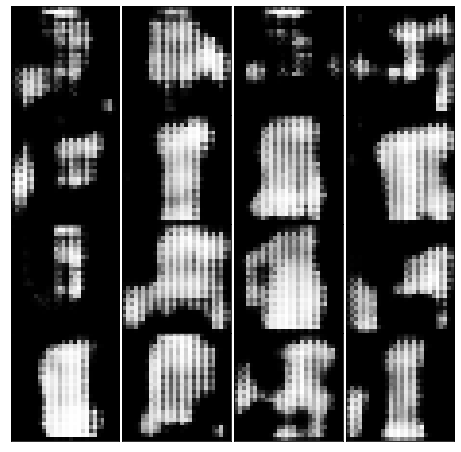

1005 [D loss: 0.013741, acc.: 100.00%] [G loss: 4.333615]
1010 [D loss: 0.027016, acc.: 99.22%] [G loss: 0.826835]
1015 [D loss: 0.013540, acc.: 100.00%] [G loss: 2.335076]
1020 [D loss: 0.064136, acc.: 98.44%] [G loss: 3.884354]
1025 [D loss: 0.119098, acc.: 96.88%] [G loss: 4.277849]
1030 [D loss: 0.032087, acc.: 99.22%] [G loss: 7.032338]
1035 [D loss: 0.033853, acc.: 100.00%] [G loss: 5.296912]
1040 [D loss: 0.042934, acc.: 98.83%] [G loss: 3.292973]
1045 [D loss: 0.057435, acc.: 98.83%] [G loss: 1.965796]
1050 [D loss: 0.038802, acc.: 99.61%] [G loss: 2.132684]
1055 [D loss: 0.029673, acc.: 100.00%] [G loss: 3.333884]
1060 [D loss: 0.095528, acc.: 99.22%] [G loss: 4.427994]
1065 [D loss: 0.126544, acc.: 94.92%] [G loss: 3.366810]
1070 [D loss: 0.015031, acc.: 100.00%] [G loss: 3.697026]
1075 [D loss: 0.002841, acc.: 100.00%] [G loss: 2.562395]
1080 [D loss: 0.009802, acc.: 100.00%] [G loss: 2.361239]
1085 [D loss: 0.013848, acc.: 100.00%] [G loss: 5.233297]
1090 [D loss: 0.550939,

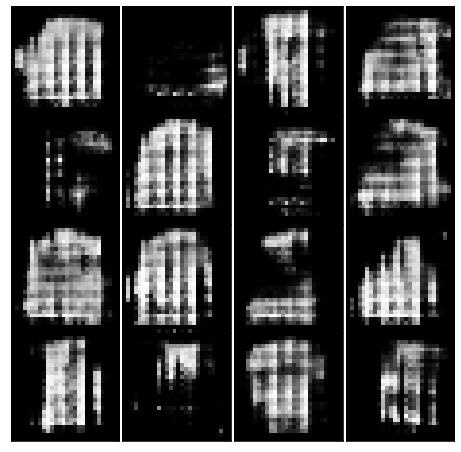

1505 [D loss: 0.039576, acc.: 98.83%] [G loss: 4.553760]
1510 [D loss: 0.014744, acc.: 99.61%] [G loss: 5.165338]
1515 [D loss: 0.006665, acc.: 100.00%] [G loss: 2.636610]
1520 [D loss: 0.010582, acc.: 100.00%] [G loss: 3.910993]
1525 [D loss: 0.056755, acc.: 98.44%] [G loss: 5.917922]
1530 [D loss: 0.142596, acc.: 94.53%] [G loss: 5.509751]
1535 [D loss: 0.653095, acc.: 74.22%] [G loss: 4.141787]
1540 [D loss: 0.030193, acc.: 99.22%] [G loss: 6.228013]
1545 [D loss: 0.057952, acc.: 98.44%] [G loss: 10.723893]
1550 [D loss: 0.027841, acc.: 98.83%] [G loss: 5.103766]
1555 [D loss: 0.007617, acc.: 100.00%] [G loss: 5.027948]
1560 [D loss: 0.018699, acc.: 100.00%] [G loss: 3.493035]
1565 [D loss: 0.072237, acc.: 98.05%] [G loss: 2.903860]
1570 [D loss: 0.052806, acc.: 97.27%] [G loss: 4.843602]
1575 [D loss: 0.020071, acc.: 99.61%] [G loss: 4.119896]
1580 [D loss: 0.027254, acc.: 99.61%] [G loss: 4.414299]
1585 [D loss: 0.007656, acc.: 100.00%] [G loss: 5.453882]
1590 [D loss: 0.076833, a

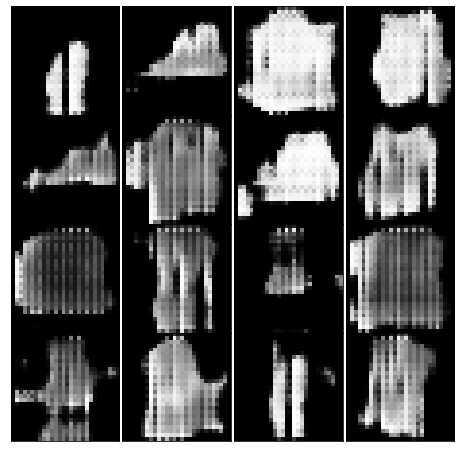

2005 [D loss: 0.022485, acc.: 99.22%] [G loss: 5.695755]
2010 [D loss: 0.028581, acc.: 100.00%] [G loss: 4.750817]
2015 [D loss: 0.028985, acc.: 99.22%] [G loss: 5.258800]
2020 [D loss: 0.036207, acc.: 99.22%] [G loss: 4.701712]
2025 [D loss: 0.044559, acc.: 99.61%] [G loss: 5.794209]
2030 [D loss: 0.020530, acc.: 99.61%] [G loss: 6.228012]
2035 [D loss: 0.026911, acc.: 99.61%] [G loss: 5.152684]
2040 [D loss: 0.009866, acc.: 100.00%] [G loss: 6.570882]
2045 [D loss: 0.017827, acc.: 100.00%] [G loss: 6.492278]
2050 [D loss: 0.024991, acc.: 99.61%] [G loss: 5.038396]
2055 [D loss: 0.049295, acc.: 99.61%] [G loss: 3.861971]
2060 [D loss: 0.029984, acc.: 100.00%] [G loss: 3.576425]
2065 [D loss: 0.072514, acc.: 98.44%] [G loss: 5.184634]
2070 [D loss: 0.020040, acc.: 100.00%] [G loss: 5.174957]
2075 [D loss: 0.073042, acc.: 97.66%] [G loss: 3.917144]
2080 [D loss: 0.137181, acc.: 93.36%] [G loss: 13.031950]
2085 [D loss: 0.001487, acc.: 100.00%] [G loss: 5.630371]
2090 [D loss: 0.005562, 

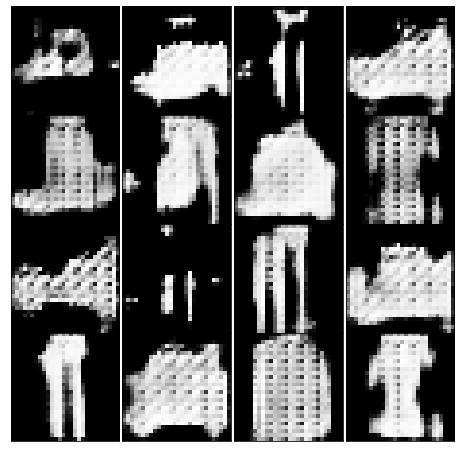

2505 [D loss: 0.033649, acc.: 99.22%] [G loss: 3.316418]
2510 [D loss: 0.039850, acc.: 99.61%] [G loss: 6.015561]
2515 [D loss: 0.039113, acc.: 99.22%] [G loss: 5.992312]
2520 [D loss: 0.027096, acc.: 99.61%] [G loss: 5.469771]
2525 [D loss: 0.026664, acc.: 100.00%] [G loss: 5.936717]
2530 [D loss: 0.013832, acc.: 100.00%] [G loss: 5.860023]
2535 [D loss: 0.018883, acc.: 99.61%] [G loss: 6.395442]
2540 [D loss: 0.021233, acc.: 100.00%] [G loss: 5.205778]
2545 [D loss: 0.029141, acc.: 99.22%] [G loss: 4.689686]
2550 [D loss: 0.038050, acc.: 98.44%] [G loss: 4.773427]
2555 [D loss: 0.018277, acc.: 99.61%] [G loss: 5.730476]
2560 [D loss: 0.055800, acc.: 98.44%] [G loss: 4.983075]
2565 [D loss: 0.030854, acc.: 99.22%] [G loss: 5.362704]
2570 [D loss: 0.019584, acc.: 100.00%] [G loss: 5.471830]
2575 [D loss: 0.546963, acc.: 76.56%] [G loss: 3.237910]
2580 [D loss: 0.019648, acc.: 100.00%] [G loss: 7.359490]
2585 [D loss: 0.005141, acc.: 100.00%] [G loss: 8.804692]
2590 [D loss: 0.037571, a

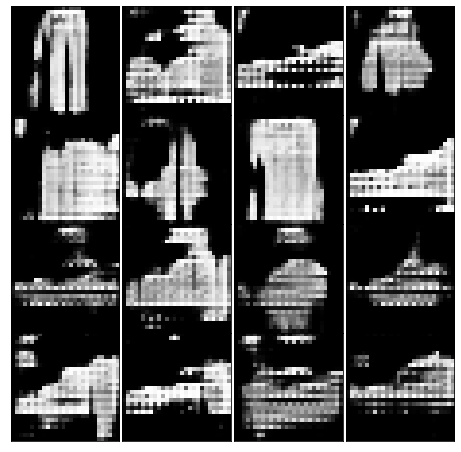

3005 [D loss: 0.037631, acc.: 99.22%] [G loss: 4.217936]
3010 [D loss: 0.009330, acc.: 100.00%] [G loss: 6.113370]
3015 [D loss: 0.017981, acc.: 99.61%] [G loss: 4.723485]
3020 [D loss: 0.005433, acc.: 100.00%] [G loss: 5.137771]
3025 [D loss: 0.009172, acc.: 100.00%] [G loss: 4.842696]
3030 [D loss: 0.005140, acc.: 100.00%] [G loss: 4.675567]
3035 [D loss: 0.006030, acc.: 100.00%] [G loss: 5.335037]
3040 [D loss: 0.014646, acc.: 100.00%] [G loss: 5.035578]
3045 [D loss: 0.026268, acc.: 99.61%] [G loss: 4.231254]
3050 [D loss: 0.023894, acc.: 99.61%] [G loss: 5.294190]
3055 [D loss: 0.015887, acc.: 100.00%] [G loss: 4.994571]
3060 [D loss: 0.014679, acc.: 100.00%] [G loss: 6.001564]
3065 [D loss: 0.029592, acc.: 99.22%] [G loss: 2.856790]
3070 [D loss: 0.016512, acc.: 99.61%] [G loss: 2.846167]
3075 [D loss: 0.049081, acc.: 98.05%] [G loss: 5.310015]
3080 [D loss: 0.010411, acc.: 100.00%] [G loss: 3.601523]
3085 [D loss: 0.008894, acc.: 100.00%] [G loss: 2.634744]
3090 [D loss: 0.00933

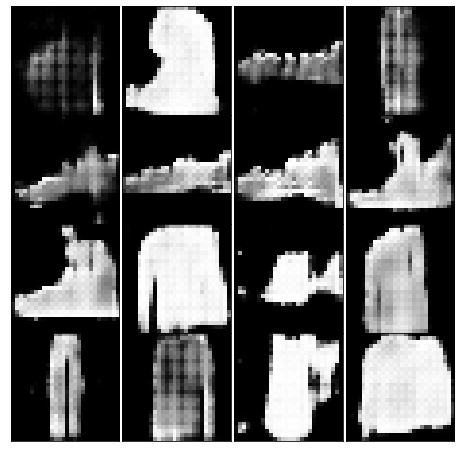

3505 [D loss: 0.022621, acc.: 100.00%] [G loss: 5.917366]
3510 [D loss: 0.023751, acc.: 99.22%] [G loss: 6.855565]
3515 [D loss: 0.626745, acc.: 73.05%] [G loss: 0.916667]
3520 [D loss: 0.003651, acc.: 100.00%] [G loss: 7.134846]
3525 [D loss: 0.007350, acc.: 99.61%] [G loss: 8.809938]
3530 [D loss: 0.007985, acc.: 100.00%] [G loss: 9.836493]
3535 [D loss: 0.016704, acc.: 99.61%] [G loss: 6.640176]
3540 [D loss: 0.046824, acc.: 98.44%] [G loss: 7.192304]
3545 [D loss: 0.042940, acc.: 98.05%] [G loss: 6.542898]
3550 [D loss: 0.014875, acc.: 100.00%] [G loss: 6.261939]
3555 [D loss: 0.024364, acc.: 100.00%] [G loss: 5.185988]
3560 [D loss: 0.013812, acc.: 99.61%] [G loss: 3.958087]
3565 [D loss: 0.052420, acc.: 99.61%] [G loss: 3.780157]
3570 [D loss: 0.074570, acc.: 96.88%] [G loss: 5.282687]
3575 [D loss: 0.019505, acc.: 100.00%] [G loss: 4.131213]
3580 [D loss: 0.014074, acc.: 99.61%] [G loss: 5.208459]
3585 [D loss: 0.008758, acc.: 100.00%] [G loss: 4.559419]
3590 [D loss: 0.024700, 

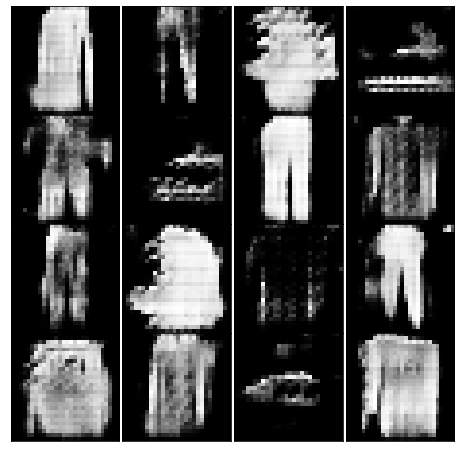

4005 [D loss: 0.006014, acc.: 100.00%] [G loss: 5.267924]
4010 [D loss: 0.074265, acc.: 97.66%] [G loss: 4.117129]
4015 [D loss: 0.040200, acc.: 98.83%] [G loss: 4.507378]
4020 [D loss: 0.011875, acc.: 100.00%] [G loss: 5.567740]
4025 [D loss: 0.026401, acc.: 99.61%] [G loss: 6.372534]
4030 [D loss: 0.012132, acc.: 100.00%] [G loss: 7.569150]
4035 [D loss: 0.044746, acc.: 98.83%] [G loss: 7.020154]
4040 [D loss: 0.025364, acc.: 99.61%] [G loss: 5.614818]
4045 [D loss: 0.028607, acc.: 98.83%] [G loss: 10.379631]
4050 [D loss: 0.004246, acc.: 100.00%] [G loss: 7.265786]
4055 [D loss: 0.021930, acc.: 99.61%] [G loss: 6.484431]
4060 [D loss: 0.077957, acc.: 98.44%] [G loss: 4.492611]
4065 [D loss: 0.022352, acc.: 100.00%] [G loss: 5.073427]
4070 [D loss: 0.038065, acc.: 99.22%] [G loss: 5.662452]
4075 [D loss: 0.017565, acc.: 99.61%] [G loss: 5.309531]
4080 [D loss: 0.025463, acc.: 99.61%] [G loss: 3.290258]
4085 [D loss: 0.121521, acc.: 94.53%] [G loss: 7.318261]
4090 [D loss: 0.549070, a

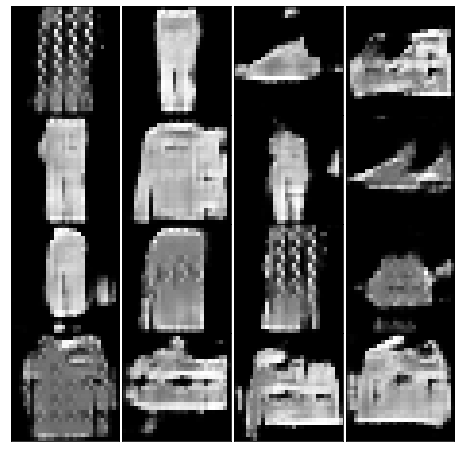

4505 [D loss: 0.023610, acc.: 99.61%] [G loss: 5.336262]
4510 [D loss: 0.034231, acc.: 99.61%] [G loss: 4.494067]
4515 [D loss: 0.037842, acc.: 99.61%] [G loss: 4.088461]
4520 [D loss: 0.012772, acc.: 100.00%] [G loss: 5.429463]
4525 [D loss: 0.023073, acc.: 99.22%] [G loss: 3.704199]
4530 [D loss: 0.039955, acc.: 98.83%] [G loss: 4.828835]
4535 [D loss: 0.011759, acc.: 100.00%] [G loss: 6.203924]
4540 [D loss: 0.018353, acc.: 99.61%] [G loss: 4.134215]
4545 [D loss: 0.043680, acc.: 99.61%] [G loss: 3.764586]
4550 [D loss: 0.031937, acc.: 99.22%] [G loss: 6.470984]
4555 [D loss: 0.012748, acc.: 99.61%] [G loss: 7.496299]
4560 [D loss: 0.010895, acc.: 100.00%] [G loss: 4.700005]
4565 [D loss: 0.013119, acc.: 100.00%] [G loss: 5.831294]
4570 [D loss: 0.024016, acc.: 99.61%] [G loss: 4.578355]
4575 [D loss: 1.945685, acc.: 59.77%] [G loss: 3.405382]
4580 [D loss: 0.452745, acc.: 82.03%] [G loss: 4.877662]
4585 [D loss: 0.128960, acc.: 96.48%] [G loss: 3.569981]
4590 [D loss: 0.045668, acc

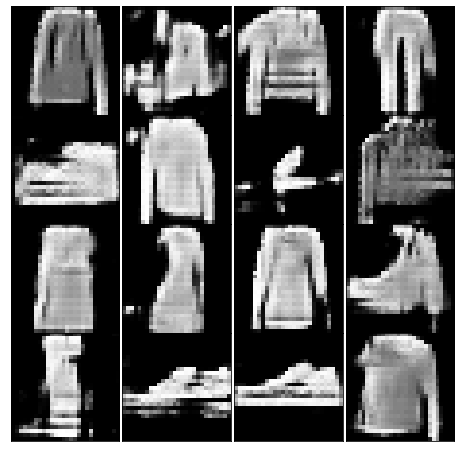

5005 [D loss: 0.027299, acc.: 99.61%] [G loss: 6.012089]
5010 [D loss: 0.022606, acc.: 99.61%] [G loss: 5.456570]
5015 [D loss: 0.010289, acc.: 100.00%] [G loss: 4.239911]
5020 [D loss: 0.011704, acc.: 100.00%] [G loss: 5.458780]
5025 [D loss: 0.021672, acc.: 99.22%] [G loss: 5.075819]
5030 [D loss: 0.023801, acc.: 99.61%] [G loss: 4.310771]
5035 [D loss: 0.009073, acc.: 100.00%] [G loss: 5.137905]
5040 [D loss: 0.074743, acc.: 98.83%] [G loss: 3.736988]
5045 [D loss: 0.016772, acc.: 99.61%] [G loss: 3.000011]
5050 [D loss: 0.017053, acc.: 100.00%] [G loss: 6.240332]
5055 [D loss: 0.010919, acc.: 100.00%] [G loss: 3.853013]
5060 [D loss: 0.008691, acc.: 100.00%] [G loss: 6.408480]
5065 [D loss: 0.008389, acc.: 100.00%] [G loss: 6.552644]
5070 [D loss: 0.007965, acc.: 100.00%] [G loss: 5.342701]
5075 [D loss: 0.032650, acc.: 98.83%] [G loss: 4.595189]
5080 [D loss: 0.048453, acc.: 99.22%] [G loss: 4.790427]
5085 [D loss: 0.216047, acc.: 89.45%] [G loss: 5.554840]
5090 [D loss: 0.187364,

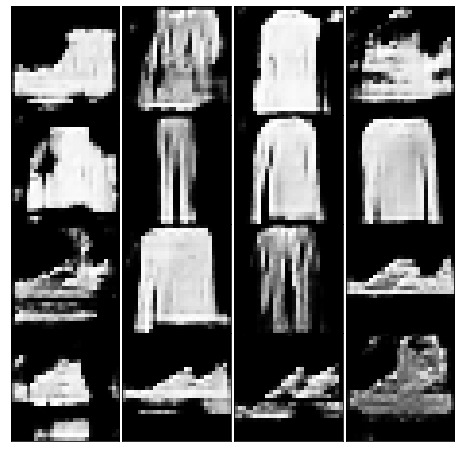

5505 [D loss: 0.080913, acc.: 98.44%] [G loss: 2.320734]
5510 [D loss: 0.089337, acc.: 96.88%] [G loss: 4.314571]
5515 [D loss: 0.188536, acc.: 91.41%] [G loss: 4.603973]
5520 [D loss: 0.023348, acc.: 100.00%] [G loss: 3.175241]
5525 [D loss: 0.015986, acc.: 99.61%] [G loss: 9.214497]
5530 [D loss: 0.006079, acc.: 100.00%] [G loss: 7.199240]
5535 [D loss: 0.037867, acc.: 98.44%] [G loss: 5.830724]
5540 [D loss: 0.010808, acc.: 100.00%] [G loss: 4.809382]
5545 [D loss: 0.041274, acc.: 99.22%] [G loss: 6.862243]
5550 [D loss: 0.019409, acc.: 99.61%] [G loss: 5.646281]
5555 [D loss: 0.021564, acc.: 99.22%] [G loss: 7.333167]
5560 [D loss: 0.020342, acc.: 99.61%] [G loss: 7.432592]
5565 [D loss: 0.020190, acc.: 100.00%] [G loss: 6.783253]
5570 [D loss: 0.007495, acc.: 100.00%] [G loss: 5.601505]
5575 [D loss: 0.022299, acc.: 100.00%] [G loss: 5.975470]
5580 [D loss: 0.094031, acc.: 96.48%] [G loss: 4.954329]
5585 [D loss: 0.017582, acc.: 99.61%] [G loss: 7.017658]
5590 [D loss: 0.014514, a

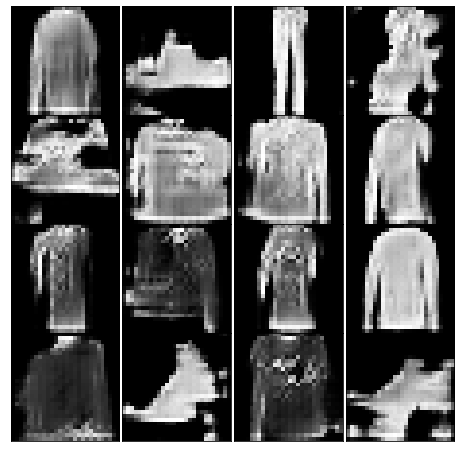

6005 [D loss: 0.048572, acc.: 98.83%] [G loss: 4.229735]
6010 [D loss: 0.097057, acc.: 96.09%] [G loss: 5.754564]
6015 [D loss: 0.014318, acc.: 100.00%] [G loss: 7.624074]
6020 [D loss: 0.044347, acc.: 98.44%] [G loss: 4.588405]
6025 [D loss: 0.057132, acc.: 98.44%] [G loss: 4.661824]
6030 [D loss: 0.054771, acc.: 98.05%] [G loss: 5.992308]
6035 [D loss: 0.075222, acc.: 98.44%] [G loss: 4.518029]
6040 [D loss: 0.063770, acc.: 98.44%] [G loss: 5.563522]
6045 [D loss: 0.028945, acc.: 100.00%] [G loss: 7.053910]
6050 [D loss: 0.037449, acc.: 98.83%] [G loss: 6.046695]
6055 [D loss: 0.086844, acc.: 98.44%] [G loss: 2.859146]
6060 [D loss: 0.149531, acc.: 93.75%] [G loss: 6.027023]
6065 [D loss: 0.042554, acc.: 99.22%] [G loss: 7.223279]
6070 [D loss: 0.085940, acc.: 96.48%] [G loss: 5.310619]
6075 [D loss: 0.028385, acc.: 99.61%] [G loss: 3.777163]
6080 [D loss: 0.068966, acc.: 98.44%] [G loss: 4.446568]
6085 [D loss: 0.049102, acc.: 99.22%] [G loss: 4.848106]
6090 [D loss: 0.025713, acc.:

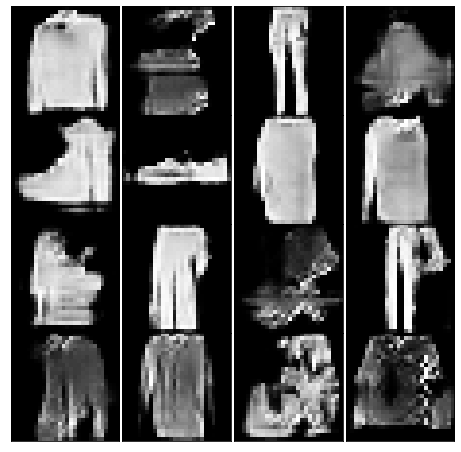

6505 [D loss: 0.149708, acc.: 94.14%] [G loss: 7.980410]
6510 [D loss: 0.024087, acc.: 99.61%] [G loss: 3.668069]
6515 [D loss: 0.009605, acc.: 100.00%] [G loss: 1.711627]
6520 [D loss: 0.062953, acc.: 98.44%] [G loss: 2.127348]
6525 [D loss: 0.030772, acc.: 99.22%] [G loss: 2.273529]
6530 [D loss: 0.036086, acc.: 98.83%] [G loss: 3.184368]
6535 [D loss: 0.046151, acc.: 99.61%] [G loss: 3.023108]
6540 [D loss: 0.118884, acc.: 94.92%] [G loss: 4.618348]
6545 [D loss: 0.016198, acc.: 100.00%] [G loss: 5.892941]
6550 [D loss: 0.076943, acc.: 98.44%] [G loss: 3.559717]
6555 [D loss: 0.042331, acc.: 99.22%] [G loss: 4.061063]
6560 [D loss: 0.071629, acc.: 98.44%] [G loss: 6.031837]
6565 [D loss: 0.025263, acc.: 99.61%] [G loss: 5.491759]
6570 [D loss: 0.060344, acc.: 98.83%] [G loss: 2.695567]
6575 [D loss: 0.106833, acc.: 97.27%] [G loss: 2.881891]
6580 [D loss: 0.029446, acc.: 99.22%] [G loss: 3.029005]
6585 [D loss: 0.018756, acc.: 100.00%] [G loss: 2.939250]
6590 [D loss: 0.034695, acc.

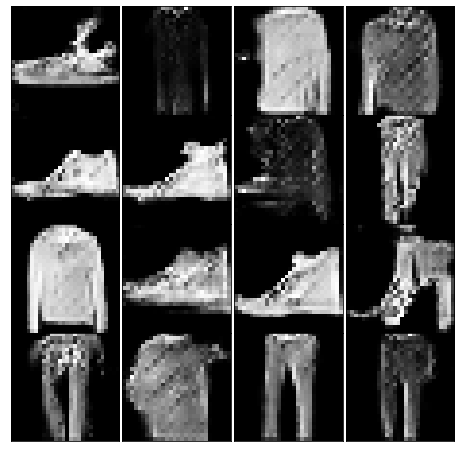

7005 [D loss: 0.142478, acc.: 94.92%] [G loss: 4.136502]
7010 [D loss: 0.034107, acc.: 99.22%] [G loss: 5.742105]
7015 [D loss: 0.071015, acc.: 97.27%] [G loss: 7.681728]
7020 [D loss: 0.093820, acc.: 96.09%] [G loss: 4.723443]
7025 [D loss: 0.032804, acc.: 99.61%] [G loss: 6.096957]
7030 [D loss: 0.028972, acc.: 99.61%] [G loss: 7.365551]
7035 [D loss: 0.018644, acc.: 99.61%] [G loss: 5.321041]
7040 [D loss: 0.021628, acc.: 99.22%] [G loss: 5.637748]
7045 [D loss: 0.012750, acc.: 100.00%] [G loss: 2.837218]
7050 [D loss: 0.045333, acc.: 98.05%] [G loss: 2.857095]
7055 [D loss: 0.020775, acc.: 100.00%] [G loss: 4.156085]
7060 [D loss: 0.010696, acc.: 100.00%] [G loss: 2.445299]
7065 [D loss: 0.006196, acc.: 100.00%] [G loss: 5.089976]
7070 [D loss: 0.119389, acc.: 94.92%] [G loss: 1.580238]
7075 [D loss: 0.258307, acc.: 88.67%] [G loss: 1.933470]
7080 [D loss: 0.031515, acc.: 98.83%] [G loss: 2.103683]
7085 [D loss: 0.010060, acc.: 100.00%] [G loss: 3.177682]
7090 [D loss: 0.015083, ac

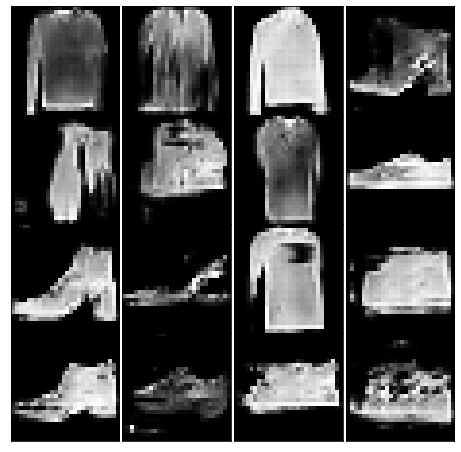

7505 [D loss: 0.051345, acc.: 98.83%] [G loss: 3.898077]
7510 [D loss: 0.072591, acc.: 97.66%] [G loss: 8.102413]
7515 [D loss: 0.023005, acc.: 100.00%] [G loss: 6.487449]
7520 [D loss: 0.096624, acc.: 97.27%] [G loss: 6.230030]
7525 [D loss: 0.189668, acc.: 91.02%] [G loss: 4.630548]
7530 [D loss: 0.072670, acc.: 98.44%] [G loss: 6.659600]
7535 [D loss: 0.050198, acc.: 98.44%] [G loss: 6.112004]
7540 [D loss: 0.042670, acc.: 98.83%] [G loss: 5.301801]
7545 [D loss: 0.015504, acc.: 99.61%] [G loss: 6.746456]
7550 [D loss: 0.014614, acc.: 99.61%] [G loss: 7.422546]
7555 [D loss: 0.058426, acc.: 98.83%] [G loss: 4.462342]
7560 [D loss: 0.035748, acc.: 99.22%] [G loss: 6.066213]
7565 [D loss: 0.035566, acc.: 99.61%] [G loss: 5.071880]
7570 [D loss: 0.016290, acc.: 100.00%] [G loss: 3.995413]
7575 [D loss: 0.127387, acc.: 96.48%] [G loss: 4.319953]
7580 [D loss: 0.055172, acc.: 98.83%] [G loss: 4.454359]
7585 [D loss: 0.088116, acc.: 97.27%] [G loss: 4.753293]
7590 [D loss: 0.045778, acc.:

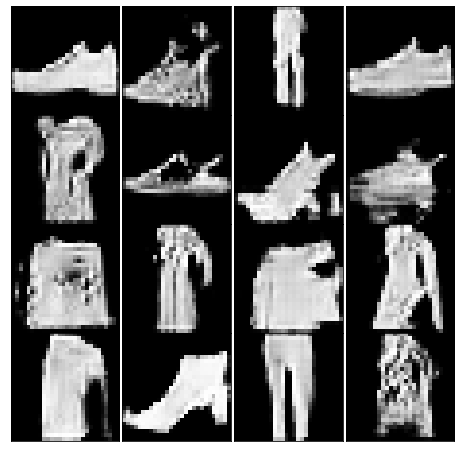

8005 [D loss: 0.071953, acc.: 98.44%] [G loss: 6.047306]
8010 [D loss: 0.011644, acc.: 100.00%] [G loss: 4.257362]
8015 [D loss: 0.049622, acc.: 98.83%] [G loss: 2.891635]
8020 [D loss: 0.116878, acc.: 95.70%] [G loss: 1.971953]
8025 [D loss: 0.171438, acc.: 91.80%] [G loss: 2.704240]
8030 [D loss: 0.552950, acc.: 73.44%] [G loss: 2.081450]
8035 [D loss: 0.086997, acc.: 96.88%] [G loss: 3.963009]
8040 [D loss: 0.059556, acc.: 98.05%] [G loss: 5.591349]
8045 [D loss: 0.036715, acc.: 99.22%] [G loss: 4.473422]
8050 [D loss: 0.100526, acc.: 96.48%] [G loss: 3.962849]
8055 [D loss: 0.035247, acc.: 99.61%] [G loss: 5.306604]
8060 [D loss: 0.061476, acc.: 98.83%] [G loss: 3.821654]
8065 [D loss: 0.035173, acc.: 99.61%] [G loss: 3.637465]
8070 [D loss: 0.195071, acc.: 91.80%] [G loss: 4.119890]
8075 [D loss: 0.054972, acc.: 99.22%] [G loss: 4.638489]
8080 [D loss: 0.042520, acc.: 100.00%] [G loss: 3.729237]
8085 [D loss: 0.050877, acc.: 99.22%] [G loss: 5.974617]
8090 [D loss: 0.064976, acc.:

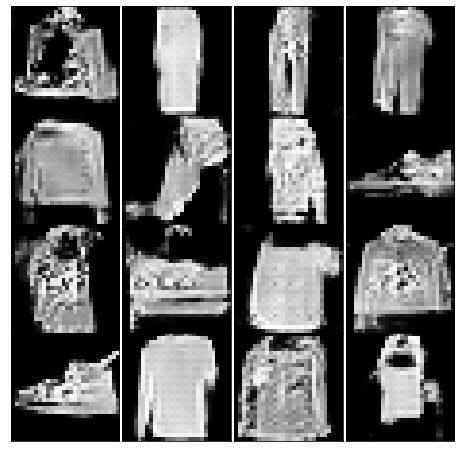

8505 [D loss: 0.048225, acc.: 99.22%] [G loss: 5.738000]
8510 [D loss: 0.058056, acc.: 98.83%] [G loss: 5.328132]
8515 [D loss: 0.066633, acc.: 98.83%] [G loss: 3.547649]
8520 [D loss: 0.054487, acc.: 98.44%] [G loss: 4.418150]
8525 [D loss: 0.040127, acc.: 98.83%] [G loss: 4.323443]
8530 [D loss: 0.028221, acc.: 99.61%] [G loss: 4.546860]
8535 [D loss: 0.047744, acc.: 99.22%] [G loss: 3.390160]
8540 [D loss: 0.042788, acc.: 98.44%] [G loss: 4.455713]
8545 [D loss: 0.045591, acc.: 98.83%] [G loss: 4.173337]
8550 [D loss: 0.062166, acc.: 98.83%] [G loss: 4.612339]
8555 [D loss: 0.276703, acc.: 88.67%] [G loss: 1.917904]
8560 [D loss: 0.033090, acc.: 99.61%] [G loss: 2.657045]
8565 [D loss: 0.036805, acc.: 99.61%] [G loss: 4.557770]
8570 [D loss: 0.031788, acc.: 99.61%] [G loss: 6.249969]
8575 [D loss: 0.059224, acc.: 98.83%] [G loss: 5.963658]
8580 [D loss: 0.050507, acc.: 98.05%] [G loss: 5.304116]
8585 [D loss: 0.038983, acc.: 99.61%] [G loss: 4.226832]
8590 [D loss: 0.093836, acc.: 9

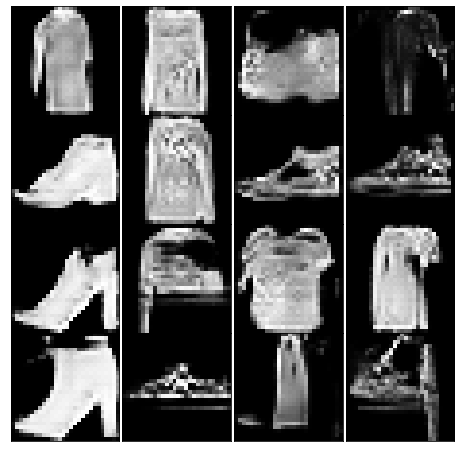

9005 [D loss: 0.074260, acc.: 97.66%] [G loss: 3.159490]
9010 [D loss: 0.131277, acc.: 94.53%] [G loss: 2.766686]
9015 [D loss: 0.104523, acc.: 96.48%] [G loss: 4.118080]
9020 [D loss: 0.146592, acc.: 94.92%] [G loss: 3.024984]
9025 [D loss: 0.092987, acc.: 97.27%] [G loss: 6.188326]
9030 [D loss: 0.037228, acc.: 99.22%] [G loss: 4.382945]
9035 [D loss: 0.081343, acc.: 96.88%] [G loss: 3.524217]
9040 [D loss: 0.057160, acc.: 99.22%] [G loss: 4.370599]
9045 [D loss: 0.063965, acc.: 98.44%] [G loss: 3.541039]
9050 [D loss: 0.041805, acc.: 99.61%] [G loss: 4.630670]
9055 [D loss: 0.026681, acc.: 99.61%] [G loss: 4.768267]
9060 [D loss: 0.128101, acc.: 96.09%] [G loss: 4.449656]
9065 [D loss: 0.111307, acc.: 97.66%] [G loss: 3.110692]
9070 [D loss: 0.048045, acc.: 98.83%] [G loss: 3.709958]
9075 [D loss: 0.031399, acc.: 99.22%] [G loss: 3.518862]
9080 [D loss: 0.054125, acc.: 98.83%] [G loss: 4.026793]
9085 [D loss: 0.055699, acc.: 98.05%] [G loss: 2.747628]
9090 [D loss: 0.026882, acc.: 9

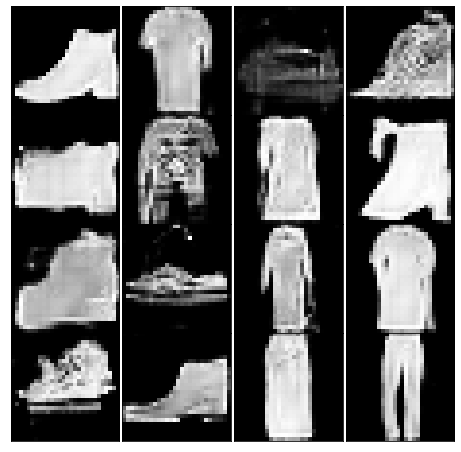

9505 [D loss: 0.144240, acc.: 93.75%] [G loss: 1.730584]
9510 [D loss: 0.029605, acc.: 99.61%] [G loss: 7.221039]
9515 [D loss: 0.043062, acc.: 99.61%] [G loss: 5.381051]
9520 [D loss: 0.127759, acc.: 94.92%] [G loss: 4.073627]
9525 [D loss: 0.127329, acc.: 96.48%] [G loss: 3.058020]
9530 [D loss: 0.064069, acc.: 98.44%] [G loss: 3.019813]
9535 [D loss: 0.038911, acc.: 99.61%] [G loss: 4.314100]
9540 [D loss: 0.139658, acc.: 93.75%] [G loss: 5.713840]
9545 [D loss: 0.043874, acc.: 98.83%] [G loss: 5.776659]
9550 [D loss: 0.189992, acc.: 92.19%] [G loss: 3.831768]
9555 [D loss: 0.015599, acc.: 100.00%] [G loss: 6.494680]
9560 [D loss: 0.129770, acc.: 94.14%] [G loss: 4.570954]
9565 [D loss: 0.101772, acc.: 96.09%] [G loss: 3.194015]
9570 [D loss: 0.051801, acc.: 98.44%] [G loss: 5.462846]
9575 [D loss: 0.016127, acc.: 100.00%] [G loss: 4.990824]
9580 [D loss: 0.021634, acc.: 99.61%] [G loss: 6.151684]
9585 [D loss: 0.092330, acc.: 96.88%] [G loss: 4.673341]
9590 [D loss: 0.041388, acc.:

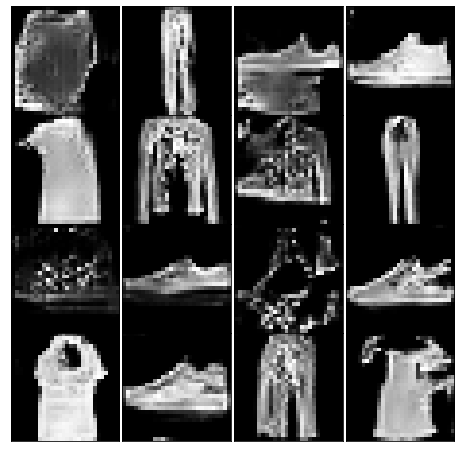

10005 [D loss: 0.086597, acc.: 97.66%] [G loss: 1.508510]
10010 [D loss: 0.039161, acc.: 99.61%] [G loss: 1.723580]
10015 [D loss: 0.062760, acc.: 98.83%] [G loss: 3.818817]
10020 [D loss: 0.022198, acc.: 100.00%] [G loss: 4.204540]
10025 [D loss: 0.025568, acc.: 99.61%] [G loss: 1.728219]
10030 [D loss: 0.212898, acc.: 91.41%] [G loss: 2.421376]
10035 [D loss: 0.118826, acc.: 96.88%] [G loss: 3.252332]
10040 [D loss: 0.057943, acc.: 98.44%] [G loss: 6.200809]
10045 [D loss: 0.031237, acc.: 99.22%] [G loss: 5.775416]
10050 [D loss: 0.051473, acc.: 98.44%] [G loss: 4.459843]
10055 [D loss: 0.034801, acc.: 99.22%] [G loss: 4.802915]
10060 [D loss: 0.031677, acc.: 99.22%] [G loss: 4.262445]
10065 [D loss: 0.043452, acc.: 99.22%] [G loss: 4.408338]
10070 [D loss: 0.016549, acc.: 99.61%] [G loss: 4.385811]
10075 [D loss: 0.020821, acc.: 100.00%] [G loss: 5.293931]
10080 [D loss: 0.070690, acc.: 98.44%] [G loss: 3.321206]
10085 [D loss: 0.111951, acc.: 97.27%] [G loss: 4.341541]
10090 [D los

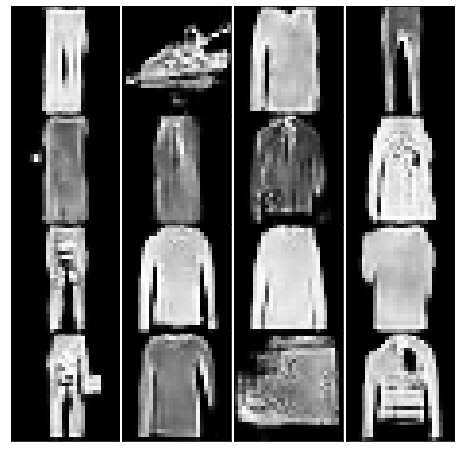

10505 [D loss: 0.017126, acc.: 100.00%] [G loss: 4.421176]
10510 [D loss: 0.066083, acc.: 99.22%] [G loss: 4.457594]
10515 [D loss: 0.012226, acc.: 100.00%] [G loss: 6.094958]
10520 [D loss: 0.052342, acc.: 99.22%] [G loss: 4.985849]
10525 [D loss: 0.049286, acc.: 99.22%] [G loss: 5.282814]
10530 [D loss: 0.102824, acc.: 96.48%] [G loss: 4.433033]
10535 [D loss: 0.085894, acc.: 97.66%] [G loss: 5.006192]
10540 [D loss: 0.026119, acc.: 100.00%] [G loss: 3.868749]
10545 [D loss: 0.131091, acc.: 94.92%] [G loss: 3.157541]
10550 [D loss: 0.033913, acc.: 100.00%] [G loss: 4.399254]
10555 [D loss: 0.191644, acc.: 92.58%] [G loss: 3.873106]
10560 [D loss: 0.112869, acc.: 96.48%] [G loss: 2.887182]
10565 [D loss: 0.036359, acc.: 100.00%] [G loss: 5.528502]
10570 [D loss: 0.021419, acc.: 99.61%] [G loss: 4.895283]
10575 [D loss: 0.054693, acc.: 98.44%] [G loss: 4.485334]
10580 [D loss: 0.082580, acc.: 98.05%] [G loss: 5.521770]
10585 [D loss: 0.070994, acc.: 98.05%] [G loss: 3.850050]
10590 [D 

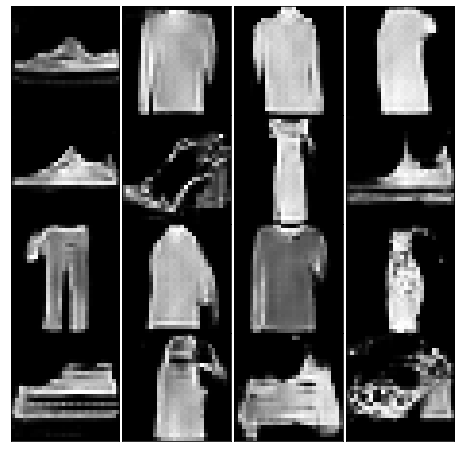

11005 [D loss: 0.017331, acc.: 100.00%] [G loss: 5.013875]
11010 [D loss: 0.012551, acc.: 100.00%] [G loss: 6.143551]
11015 [D loss: 0.030353, acc.: 99.22%] [G loss: 4.387006]
11020 [D loss: 0.081506, acc.: 98.44%] [G loss: 4.228230]
11025 [D loss: 0.048045, acc.: 99.22%] [G loss: 4.527535]
11030 [D loss: 0.040302, acc.: 99.61%] [G loss: 3.693176]
11035 [D loss: 0.055820, acc.: 99.61%] [G loss: 4.043996]
11040 [D loss: 0.041068, acc.: 98.83%] [G loss: 3.324693]
11045 [D loss: 0.090999, acc.: 95.70%] [G loss: 3.718032]
11050 [D loss: 0.107015, acc.: 96.09%] [G loss: 4.673369]
11055 [D loss: 0.188088, acc.: 90.62%] [G loss: 2.939001]
11060 [D loss: 0.025087, acc.: 99.61%] [G loss: 4.883254]
11065 [D loss: 0.068537, acc.: 98.05%] [G loss: 4.150099]
11070 [D loss: 0.070759, acc.: 97.66%] [G loss: 4.555524]
11075 [D loss: 0.006453, acc.: 100.00%] [G loss: 4.269792]
11080 [D loss: 0.014999, acc.: 100.00%] [G loss: 3.065177]
11085 [D loss: 0.105478, acc.: 95.70%] [G loss: 3.789515]
11090 [D l

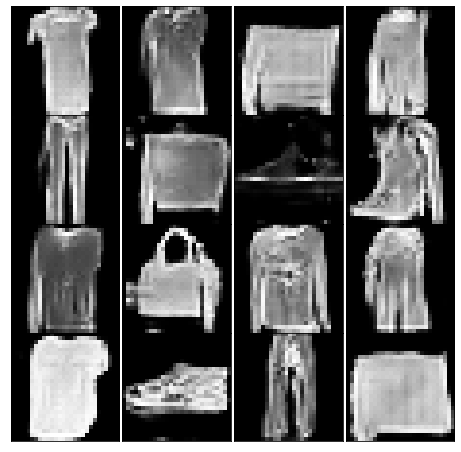

11505 [D loss: 0.014191, acc.: 100.00%] [G loss: 5.446521]
11510 [D loss: 0.071763, acc.: 97.27%] [G loss: 4.256089]
11515 [D loss: 0.191779, acc.: 92.19%] [G loss: 4.239119]
11520 [D loss: 0.040704, acc.: 98.83%] [G loss: 2.988951]
11525 [D loss: 0.077637, acc.: 97.66%] [G loss: 3.064656]
11530 [D loss: 0.050250, acc.: 98.83%] [G loss: 3.780243]
11535 [D loss: 0.059575, acc.: 98.44%] [G loss: 4.825520]
11540 [D loss: 0.251069, acc.: 87.89%] [G loss: 4.554296]
11545 [D loss: 0.080507, acc.: 98.05%] [G loss: 4.974790]
11550 [D loss: 0.039615, acc.: 99.22%] [G loss: 7.327594]
11555 [D loss: 0.027894, acc.: 99.61%] [G loss: 2.884289]
11560 [D loss: 0.110832, acc.: 96.09%] [G loss: 3.877890]
11565 [D loss: 0.055634, acc.: 98.83%] [G loss: 3.057367]
11570 [D loss: 0.081775, acc.: 98.05%] [G loss: 4.005843]
11575 [D loss: 0.281084, acc.: 85.55%] [G loss: 2.135777]
11580 [D loss: 0.052036, acc.: 99.61%] [G loss: 3.421897]
11585 [D loss: 0.287536, acc.: 88.28%] [G loss: 1.986913]
11590 [D loss

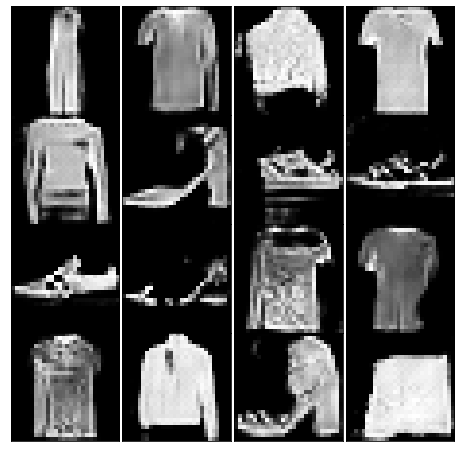

12005 [D loss: 0.022362, acc.: 100.00%] [G loss: 6.911067]
12010 [D loss: 0.070362, acc.: 98.05%] [G loss: 5.212265]
12015 [D loss: 0.037362, acc.: 99.61%] [G loss: 4.084993]
12020 [D loss: 0.063560, acc.: 98.44%] [G loss: 4.636072]
12025 [D loss: 0.066414, acc.: 98.05%] [G loss: 3.937079]
12030 [D loss: 0.031751, acc.: 99.61%] [G loss: 3.562906]
12035 [D loss: 0.083150, acc.: 97.27%] [G loss: 4.244168]
12040 [D loss: 0.045460, acc.: 99.22%] [G loss: 7.349121]
12045 [D loss: 0.028125, acc.: 100.00%] [G loss: 6.063460]
12050 [D loss: 0.047128, acc.: 98.83%] [G loss: 4.393359]
12055 [D loss: 0.219136, acc.: 90.23%] [G loss: 3.937349]
12060 [D loss: 0.137187, acc.: 93.75%] [G loss: 4.143158]
12065 [D loss: 0.120625, acc.: 95.70%] [G loss: 3.356795]
12070 [D loss: 0.191441, acc.: 90.62%] [G loss: 1.557580]
12075 [D loss: 0.055591, acc.: 98.44%] [G loss: 2.925183]
12080 [D loss: 0.036450, acc.: 99.61%] [G loss: 3.638062]
12085 [D loss: 0.628738, acc.: 74.22%] [G loss: 2.445556]
12090 [D los

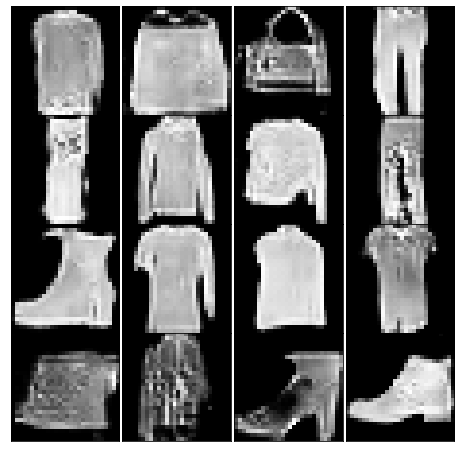

12505 [D loss: 0.065686, acc.: 98.05%] [G loss: 5.345920]
12510 [D loss: 0.037147, acc.: 100.00%] [G loss: 4.606953]
12515 [D loss: 0.085509, acc.: 97.66%] [G loss: 5.842944]
12520 [D loss: 0.039368, acc.: 99.22%] [G loss: 6.240355]
12525 [D loss: 0.098206, acc.: 97.27%] [G loss: 5.919125]
12530 [D loss: 0.022193, acc.: 100.00%] [G loss: 6.604086]
12535 [D loss: 0.021956, acc.: 100.00%] [G loss: 5.600160]
12540 [D loss: 0.059862, acc.: 99.22%] [G loss: 4.231142]
12545 [D loss: 0.024616, acc.: 99.22%] [G loss: 5.724199]
12550 [D loss: 0.052987, acc.: 98.83%] [G loss: 6.057907]
12555 [D loss: 0.140996, acc.: 94.92%] [G loss: 5.918494]
12560 [D loss: 0.023188, acc.: 99.61%] [G loss: 5.654600]
12565 [D loss: 0.006287, acc.: 100.00%] [G loss: 6.892379]
12570 [D loss: 0.038885, acc.: 99.61%] [G loss: 4.760184]
12575 [D loss: 0.134057, acc.: 94.92%] [G loss: 5.549013]
12580 [D loss: 0.025542, acc.: 100.00%] [G loss: 8.682498]
12585 [D loss: 0.170643, acc.: 92.58%] [G loss: 8.473991]
12590 [D 

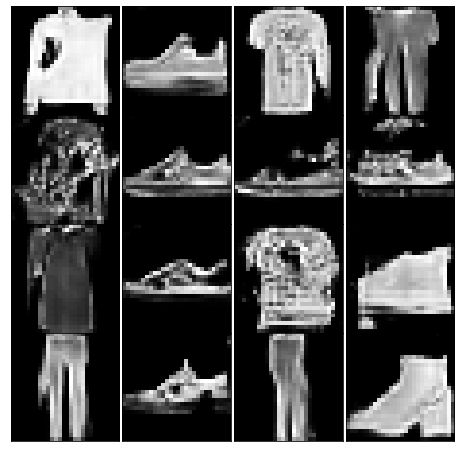

13005 [D loss: 0.022852, acc.: 99.61%] [G loss: 6.262855]
13010 [D loss: 0.014382, acc.: 100.00%] [G loss: 6.356974]
13015 [D loss: 0.085483, acc.: 98.05%] [G loss: 5.686340]
13020 [D loss: 0.041557, acc.: 98.83%] [G loss: 5.663281]
13025 [D loss: 0.053183, acc.: 98.83%] [G loss: 4.509085]
13030 [D loss: 0.010186, acc.: 100.00%] [G loss: 6.316537]
13035 [D loss: 0.023340, acc.: 99.61%] [G loss: 5.588772]
13040 [D loss: 0.039175, acc.: 98.83%] [G loss: 5.221107]
13045 [D loss: 0.058588, acc.: 100.00%] [G loss: 5.927231]
13050 [D loss: 0.046342, acc.: 98.83%] [G loss: 4.115176]
13055 [D loss: 0.119567, acc.: 94.92%] [G loss: 4.901175]
13060 [D loss: 0.051068, acc.: 99.22%] [G loss: 3.029233]
13065 [D loss: 0.092514, acc.: 97.66%] [G loss: 3.806334]
13070 [D loss: 0.048028, acc.: 99.22%] [G loss: 5.834339]
13075 [D loss: 0.068840, acc.: 98.05%] [G loss: 5.026312]
13080 [D loss: 0.048746, acc.: 98.83%] [G loss: 3.537176]
13085 [D loss: 0.048263, acc.: 98.83%] [G loss: 4.479826]
13090 [D lo

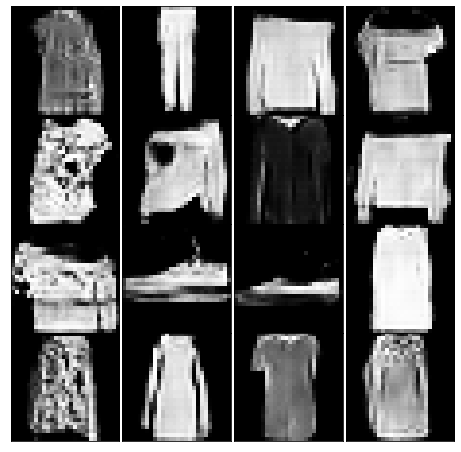

13505 [D loss: 0.051111, acc.: 98.05%] [G loss: 4.091637]
13510 [D loss: 0.040251, acc.: 99.22%] [G loss: 4.095782]
13515 [D loss: 0.066737, acc.: 99.22%] [G loss: 4.232838]
13520 [D loss: 0.073929, acc.: 97.66%] [G loss: 4.559430]
13525 [D loss: 0.053862, acc.: 99.61%] [G loss: 3.298617]
13530 [D loss: 0.175045, acc.: 92.58%] [G loss: 2.410092]
13535 [D loss: 0.131304, acc.: 94.14%] [G loss: 2.214647]
13540 [D loss: 0.175192, acc.: 92.58%] [G loss: 5.306828]
13545 [D loss: 0.096981, acc.: 96.48%] [G loss: 4.517307]
13550 [D loss: 0.064174, acc.: 98.05%] [G loss: 4.475087]
13555 [D loss: 0.227398, acc.: 90.62%] [G loss: 2.428531]
13560 [D loss: 0.031862, acc.: 99.61%] [G loss: 4.604543]
13565 [D loss: 0.081415, acc.: 99.61%] [G loss: 5.280175]
13570 [D loss: 0.035677, acc.: 100.00%] [G loss: 4.494935]
13575 [D loss: 0.019482, acc.: 100.00%] [G loss: 4.967957]
13580 [D loss: 0.045248, acc.: 99.61%] [G loss: 5.778000]
13585 [D loss: 0.083538, acc.: 98.05%] [G loss: 4.781055]
13590 [D los

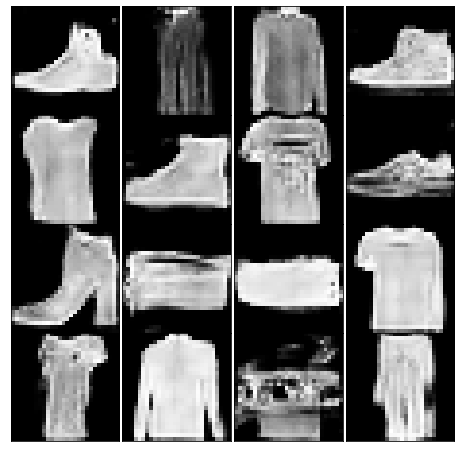

14005 [D loss: 0.113587, acc.: 95.70%] [G loss: 4.575169]
14010 [D loss: 0.084468, acc.: 95.70%] [G loss: 8.172926]
14015 [D loss: 0.043125, acc.: 98.44%] [G loss: 6.123538]
14020 [D loss: 0.020136, acc.: 100.00%] [G loss: 5.222132]
14025 [D loss: 0.027813, acc.: 99.61%] [G loss: 4.014531]
14030 [D loss: 0.033046, acc.: 99.61%] [G loss: 4.561644]
14035 [D loss: 0.139661, acc.: 95.31%] [G loss: 2.930569]
14040 [D loss: 0.090611, acc.: 97.66%] [G loss: 3.576989]
14045 [D loss: 0.024839, acc.: 100.00%] [G loss: 3.026101]
14050 [D loss: 0.039976, acc.: 99.22%] [G loss: 6.998517]
14055 [D loss: 0.106883, acc.: 96.48%] [G loss: 3.498051]
14060 [D loss: 0.057468, acc.: 99.22%] [G loss: 3.748018]
14065 [D loss: 0.007310, acc.: 100.00%] [G loss: 6.922032]
14070 [D loss: 0.035868, acc.: 99.61%] [G loss: 4.290421]
14075 [D loss: 0.026684, acc.: 99.22%] [G loss: 4.093189]
14080 [D loss: 0.051259, acc.: 99.61%] [G loss: 4.004582]
14085 [D loss: 0.042112, acc.: 99.22%] [G loss: 5.485595]
14090 [D lo

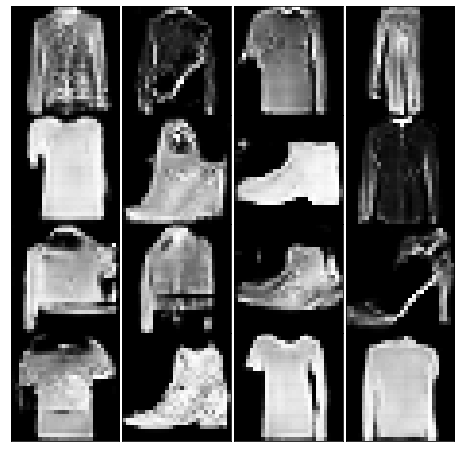

14505 [D loss: 0.103546, acc.: 96.88%] [G loss: 4.770576]
14510 [D loss: 0.079298, acc.: 98.05%] [G loss: 4.989250]
14515 [D loss: 0.045798, acc.: 99.22%] [G loss: 5.489758]
14520 [D loss: 0.029617, acc.: 99.22%] [G loss: 4.050194]
14525 [D loss: 0.042014, acc.: 99.61%] [G loss: 4.020752]
14530 [D loss: 0.064611, acc.: 98.44%] [G loss: 5.243759]
14535 [D loss: 0.016139, acc.: 99.61%] [G loss: 6.252557]
14540 [D loss: 0.033780, acc.: 99.61%] [G loss: 2.889316]
14545 [D loss: 0.016602, acc.: 100.00%] [G loss: 3.074320]
14550 [D loss: 0.033650, acc.: 99.22%] [G loss: 2.763206]
14555 [D loss: 0.108685, acc.: 96.48%] [G loss: 2.498110]
14560 [D loss: 0.100455, acc.: 96.88%] [G loss: 5.605820]
14565 [D loss: 0.038926, acc.: 99.22%] [G loss: 7.979602]
14570 [D loss: 0.033430, acc.: 99.22%] [G loss: 7.085128]
14575 [D loss: 0.044462, acc.: 98.83%] [G loss: 4.487363]
14580 [D loss: 0.049033, acc.: 99.22%] [G loss: 4.090205]
14585 [D loss: 0.072100, acc.: 98.05%] [G loss: 4.022221]
14590 [D loss

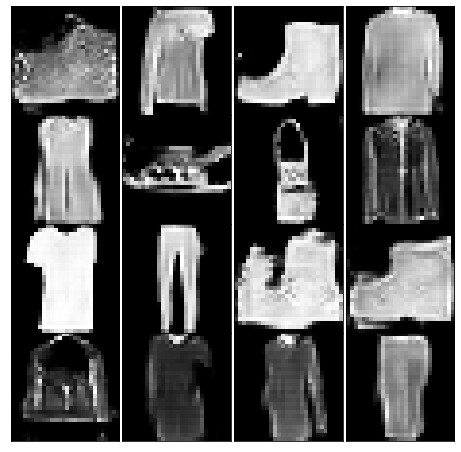

15005 [D loss: 0.078922, acc.: 97.27%] [G loss: 4.572401]
15010 [D loss: 0.021250, acc.: 99.61%] [G loss: 4.925705]
15015 [D loss: 0.115839, acc.: 98.44%] [G loss: 6.679372]
15020 [D loss: 0.026083, acc.: 99.61%] [G loss: 7.117791]
15025 [D loss: 0.093335, acc.: 96.48%] [G loss: 4.696750]
15030 [D loss: 0.036947, acc.: 99.22%] [G loss: 4.799645]
15035 [D loss: 0.029609, acc.: 99.61%] [G loss: 3.968413]
15040 [D loss: 0.072908, acc.: 98.05%] [G loss: 3.477830]
15045 [D loss: 0.101544, acc.: 96.09%] [G loss: 4.816732]
15050 [D loss: 0.051166, acc.: 99.22%] [G loss: 5.045529]
15055 [D loss: 0.138993, acc.: 95.31%] [G loss: 3.408872]
15060 [D loss: 0.098295, acc.: 97.66%] [G loss: 2.684607]
15065 [D loss: 0.029406, acc.: 100.00%] [G loss: 5.561483]
15070 [D loss: 0.020121, acc.: 99.61%] [G loss: 6.610608]
15075 [D loss: 0.037118, acc.: 99.61%] [G loss: 5.273404]
15080 [D loss: 0.036760, acc.: 99.61%] [G loss: 3.787793]
15085 [D loss: 0.094087, acc.: 97.27%] [G loss: 3.714005]
15090 [D loss

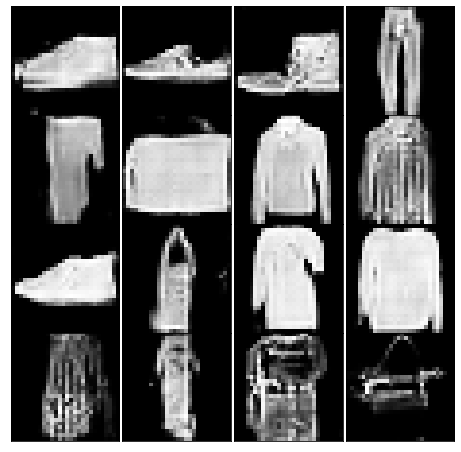

15505 [D loss: 0.047453, acc.: 99.61%] [G loss: 10.069520]
15510 [D loss: 0.023605, acc.: 99.61%] [G loss: 8.660292]
15515 [D loss: 0.065920, acc.: 99.61%] [G loss: 6.249909]
15520 [D loss: 0.021494, acc.: 100.00%] [G loss: 6.375595]
15525 [D loss: 0.024297, acc.: 99.61%] [G loss: 7.040262]
15530 [D loss: 0.045459, acc.: 99.22%] [G loss: 4.632115]
15535 [D loss: 0.067404, acc.: 98.44%] [G loss: 8.175312]
15540 [D loss: 0.010497, acc.: 100.00%] [G loss: 6.901815]
15545 [D loss: 0.034956, acc.: 99.61%] [G loss: 4.451275]
15550 [D loss: 0.014875, acc.: 100.00%] [G loss: 5.785199]
15555 [D loss: 0.052249, acc.: 99.61%] [G loss: 5.747177]
15560 [D loss: 0.025229, acc.: 99.61%] [G loss: 4.263913]
15565 [D loss: 0.022725, acc.: 99.22%] [G loss: 5.015495]
15570 [D loss: 0.055275, acc.: 98.83%] [G loss: 3.549263]
15575 [D loss: 0.029820, acc.: 99.61%] [G loss: 6.371033]
15580 [D loss: 0.043774, acc.: 99.22%] [G loss: 6.301126]
15585 [D loss: 0.062009, acc.: 98.05%] [G loss: 5.820597]
15590 [D l

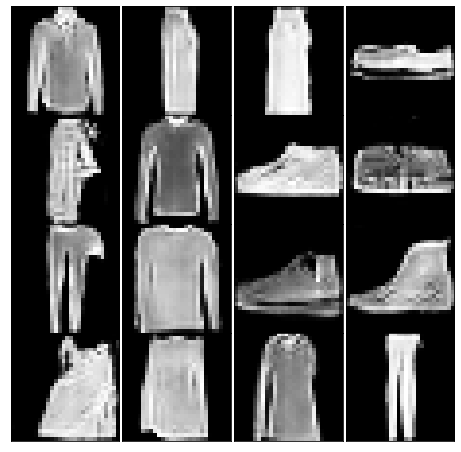

16005 [D loss: 0.107851, acc.: 95.31%] [G loss: 3.253708]
16010 [D loss: 0.354353, acc.: 79.30%] [G loss: 2.267919]
16015 [D loss: 0.071905, acc.: 97.27%] [G loss: 4.670142]
16020 [D loss: 0.033625, acc.: 99.61%] [G loss: 5.561233]
16025 [D loss: 0.082986, acc.: 97.27%] [G loss: 7.638161]
16030 [D loss: 0.129173, acc.: 95.70%] [G loss: 6.018005]
16035 [D loss: 0.136441, acc.: 92.97%] [G loss: 3.219060]
16040 [D loss: 0.030459, acc.: 100.00%] [G loss: 5.171945]
16045 [D loss: 0.057998, acc.: 98.44%] [G loss: 3.896722]
16050 [D loss: 0.045433, acc.: 99.22%] [G loss: 6.036832]
16055 [D loss: 0.016248, acc.: 99.61%] [G loss: 4.270226]
16060 [D loss: 0.036880, acc.: 100.00%] [G loss: 2.774675]
16065 [D loss: 0.116474, acc.: 96.48%] [G loss: 6.485503]
16070 [D loss: 0.044280, acc.: 99.61%] [G loss: 7.501479]
16075 [D loss: 0.023490, acc.: 99.61%] [G loss: 7.705863]
16080 [D loss: 0.023121, acc.: 100.00%] [G loss: 5.195996]
16085 [D loss: 0.086854, acc.: 97.27%] [G loss: 5.344946]
16090 [D lo

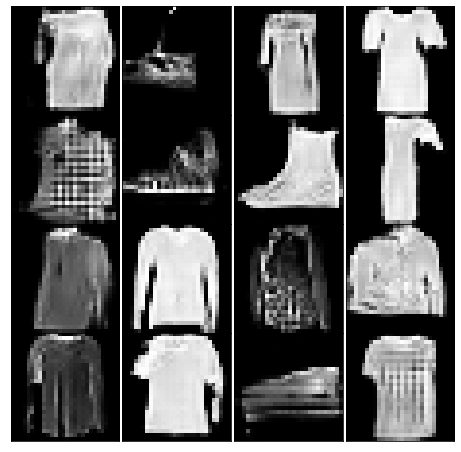

16505 [D loss: 0.046033, acc.: 98.44%] [G loss: 9.669834]
16510 [D loss: 0.006558, acc.: 100.00%] [G loss: 10.794036]
16515 [D loss: 0.007074, acc.: 100.00%] [G loss: 10.021907]
16520 [D loss: 0.035478, acc.: 99.61%] [G loss: 11.833632]
16525 [D loss: 0.022736, acc.: 99.61%] [G loss: 8.468520]
16530 [D loss: 0.019222, acc.: 100.00%] [G loss: 10.499765]
16535 [D loss: 0.041491, acc.: 99.61%] [G loss: 5.925646]
16540 [D loss: 0.042242, acc.: 98.83%] [G loss: 4.586321]
16545 [D loss: 0.027689, acc.: 99.22%] [G loss: 3.657380]
16550 [D loss: 0.021272, acc.: 99.61%] [G loss: 3.637291]
16555 [D loss: 0.008394, acc.: 100.00%] [G loss: 3.873309]
16560 [D loss: 0.047004, acc.: 98.44%] [G loss: 3.523149]
16565 [D loss: 0.026270, acc.: 99.61%] [G loss: 4.967284]
16570 [D loss: 0.031823, acc.: 99.61%] [G loss: 5.045382]
16575 [D loss: 0.017562, acc.: 99.61%] [G loss: 6.263286]
16580 [D loss: 0.012321, acc.: 100.00%] [G loss: 5.744821]
16585 [D loss: 0.018029, acc.: 100.00%] [G loss: 6.532876]
1659

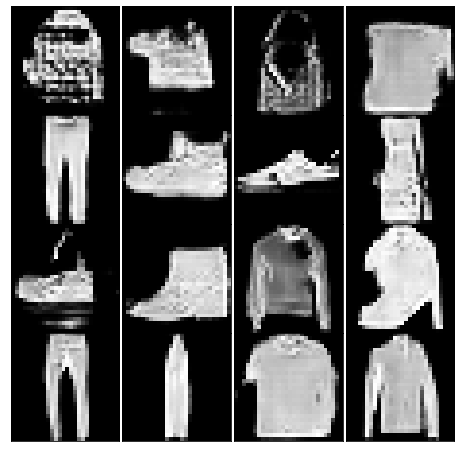

17005 [D loss: 0.063919, acc.: 98.05%] [G loss: 3.301228]
17010 [D loss: 0.087893, acc.: 96.88%] [G loss: 3.509639]
17015 [D loss: 0.047870, acc.: 98.44%] [G loss: 2.234982]
17020 [D loss: 0.142536, acc.: 94.92%] [G loss: 2.015052]
17025 [D loss: 0.049895, acc.: 98.44%] [G loss: 5.054677]
17030 [D loss: 0.033972, acc.: 98.83%] [G loss: 3.830731]
17035 [D loss: 0.036963, acc.: 99.61%] [G loss: 2.805900]
17040 [D loss: 0.058397, acc.: 98.44%] [G loss: 3.584502]
17045 [D loss: 0.275315, acc.: 85.16%] [G loss: 6.113787]
17050 [D loss: 0.027233, acc.: 99.61%] [G loss: 6.852782]
17055 [D loss: 0.066852, acc.: 97.66%] [G loss: 2.798452]
17060 [D loss: 0.137122, acc.: 96.09%] [G loss: 3.207307]
17065 [D loss: 0.157611, acc.: 92.97%] [G loss: 5.780567]
17070 [D loss: 0.034282, acc.: 99.61%] [G loss: 6.487434]
17075 [D loss: 0.047360, acc.: 99.22%] [G loss: 4.016144]
17080 [D loss: 0.094131, acc.: 96.48%] [G loss: 6.699933]
17085 [D loss: 0.020336, acc.: 99.61%] [G loss: 5.682189]
17090 [D loss:

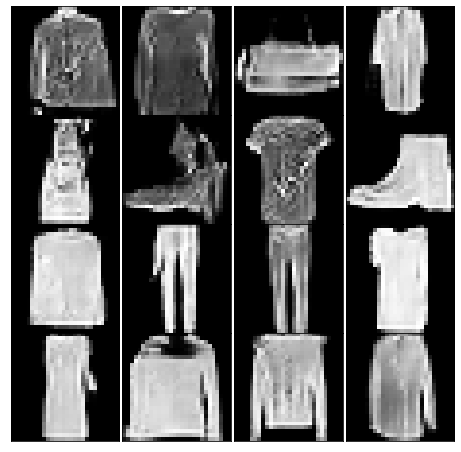

17505 [D loss: 0.223697, acc.: 90.23%] [G loss: 4.662522]
17510 [D loss: 0.178151, acc.: 90.62%] [G loss: 5.038818]
17515 [D loss: 0.031046, acc.: 98.83%] [G loss: 7.537845]
17520 [D loss: 0.151136, acc.: 92.97%] [G loss: 7.228754]
17525 [D loss: 0.023335, acc.: 99.61%] [G loss: 6.582064]
17530 [D loss: 0.037050, acc.: 99.22%] [G loss: 7.178787]
17535 [D loss: 0.047151, acc.: 98.83%] [G loss: 7.867362]
17540 [D loss: 0.709654, acc.: 69.92%] [G loss: 6.508273]
17545 [D loss: 0.052499, acc.: 98.83%] [G loss: 4.365131]
17550 [D loss: 0.043791, acc.: 99.61%] [G loss: 5.134507]
17555 [D loss: 0.066521, acc.: 97.66%] [G loss: 4.395734]
17560 [D loss: 0.194277, acc.: 91.80%] [G loss: 1.330728]
17565 [D loss: 0.051384, acc.: 98.83%] [G loss: 4.261526]
17570 [D loss: 0.009685, acc.: 100.00%] [G loss: 11.357812]
17575 [D loss: 0.004965, acc.: 100.00%] [G loss: 12.668013]
17580 [D loss: 0.004845, acc.: 99.61%] [G loss: 13.320702]
17585 [D loss: 0.008019, acc.: 99.61%] [G loss: 13.116390]
17590 [D

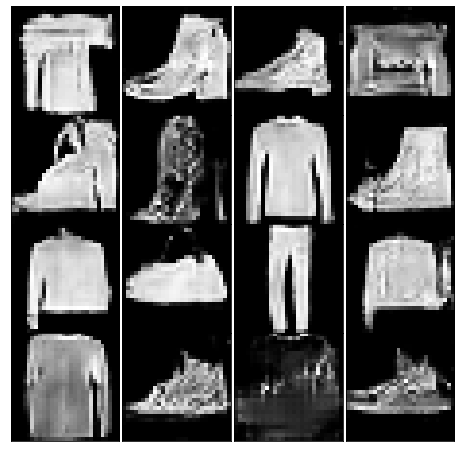

18005 [D loss: 0.084228, acc.: 96.48%] [G loss: 3.523685]
18010 [D loss: 0.083473, acc.: 97.27%] [G loss: 4.222525]
18015 [D loss: 0.042610, acc.: 98.44%] [G loss: 6.110449]
18020 [D loss: 0.065455, acc.: 98.44%] [G loss: 4.755834]
18025 [D loss: 0.056668, acc.: 98.83%] [G loss: 4.479511]
18030 [D loss: 0.062116, acc.: 98.05%] [G loss: 5.063621]
18035 [D loss: 0.024128, acc.: 100.00%] [G loss: 4.344845]
18040 [D loss: 0.061314, acc.: 97.66%] [G loss: 5.222446]
18045 [D loss: 0.012757, acc.: 100.00%] [G loss: 6.339404]
18050 [D loss: 0.047229, acc.: 99.22%] [G loss: 5.727724]
18055 [D loss: 0.073424, acc.: 97.66%] [G loss: 5.554468]
18060 [D loss: 0.105594, acc.: 96.09%] [G loss: 4.745500]
18065 [D loss: 0.026584, acc.: 99.61%] [G loss: 5.516643]
18070 [D loss: 0.043868, acc.: 98.83%] [G loss: 5.564550]
18075 [D loss: 0.048420, acc.: 99.61%] [G loss: 4.585456]
18080 [D loss: 0.056737, acc.: 98.83%] [G loss: 5.052615]
18085 [D loss: 0.051440, acc.: 98.83%] [G loss: 4.321276]
18090 [D los

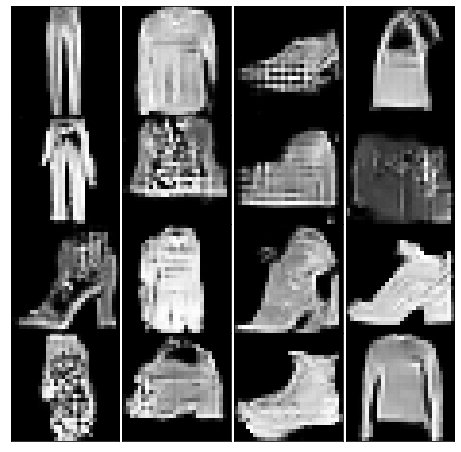

18505 [D loss: 0.263239, acc.: 87.89%] [G loss: 6.884098]
18510 [D loss: 0.064547, acc.: 97.27%] [G loss: 10.465742]
18515 [D loss: 0.042039, acc.: 99.61%] [G loss: 5.187998]
18520 [D loss: 0.030163, acc.: 100.00%] [G loss: 3.429399]
18525 [D loss: 0.076418, acc.: 97.66%] [G loss: 4.913637]
18530 [D loss: 0.063487, acc.: 99.61%] [G loss: 5.016415]
18535 [D loss: 0.023727, acc.: 100.00%] [G loss: 5.018553]
18540 [D loss: 0.104487, acc.: 96.88%] [G loss: 4.369009]
18545 [D loss: 0.370900, acc.: 79.69%] [G loss: 4.657784]
18550 [D loss: 0.049316, acc.: 98.44%] [G loss: 4.476100]
18555 [D loss: 0.080147, acc.: 97.66%] [G loss: 5.331907]
18560 [D loss: 0.030500, acc.: 99.61%] [G loss: 4.195255]
18565 [D loss: 0.047149, acc.: 100.00%] [G loss: 2.423582]
18570 [D loss: 0.069019, acc.: 98.44%] [G loss: 3.495842]
18575 [D loss: 0.063842, acc.: 99.61%] [G loss: 3.401881]
18580 [D loss: 0.041260, acc.: 99.22%] [G loss: 3.883709]
18585 [D loss: 0.020746, acc.: 99.61%] [G loss: 5.890504]
18590 [D l

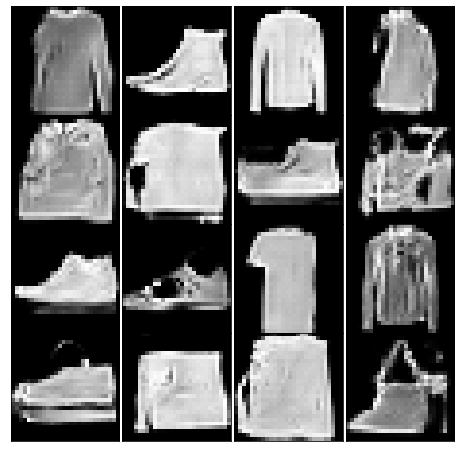

19005 [D loss: 0.040408, acc.: 99.61%] [G loss: 6.205716]
19010 [D loss: 0.012172, acc.: 100.00%] [G loss: 5.563887]
19015 [D loss: 0.024098, acc.: 99.22%] [G loss: 5.663684]
19020 [D loss: 0.037920, acc.: 99.61%] [G loss: 5.353981]
19025 [D loss: 0.024706, acc.: 99.61%] [G loss: 6.422503]
19030 [D loss: 0.042192, acc.: 99.22%] [G loss: 3.770449]
19035 [D loss: 0.186380, acc.: 92.97%] [G loss: 4.975370]
19040 [D loss: 0.091653, acc.: 97.27%] [G loss: 7.781059]
19045 [D loss: 0.083717, acc.: 97.27%] [G loss: 4.422298]
19050 [D loss: 0.110058, acc.: 97.27%] [G loss: 3.100743]
19055 [D loss: 0.044176, acc.: 99.22%] [G loss: 5.524629]
19060 [D loss: 0.049283, acc.: 98.44%] [G loss: 3.688344]
19065 [D loss: 0.045331, acc.: 98.83%] [G loss: 5.851875]
19070 [D loss: 0.068669, acc.: 98.44%] [G loss: 5.642907]
19075 [D loss: 0.023229, acc.: 100.00%] [G loss: 3.574709]
19080 [D loss: 0.009136, acc.: 100.00%] [G loss: 5.065062]
19085 [D loss: 0.016690, acc.: 100.00%] [G loss: 5.371605]
19090 [D l

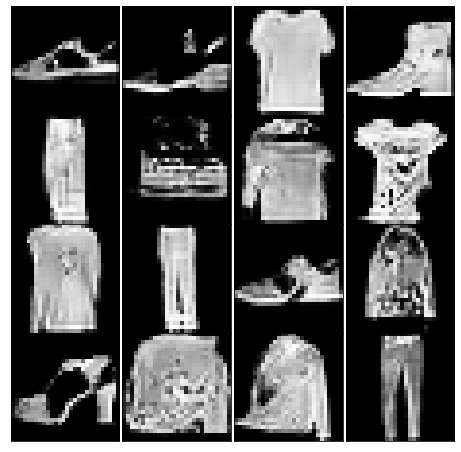

19505 [D loss: 0.043865, acc.: 100.00%] [G loss: 4.786523]
19510 [D loss: 0.029032, acc.: 99.61%] [G loss: 5.099786]
19515 [D loss: 0.019792, acc.: 99.61%] [G loss: 5.627279]
19520 [D loss: 0.031739, acc.: 100.00%] [G loss: 4.409353]
19525 [D loss: 0.078664, acc.: 98.83%] [G loss: 3.782316]
19530 [D loss: 0.188386, acc.: 91.41%] [G loss: 5.260893]
19535 [D loss: 0.031694, acc.: 100.00%] [G loss: 5.500272]
19540 [D loss: 0.038607, acc.: 99.22%] [G loss: 5.896880]
19545 [D loss: 0.055413, acc.: 99.61%] [G loss: 6.757539]
19550 [D loss: 0.050183, acc.: 99.22%] [G loss: 5.571377]
19555 [D loss: 0.023778, acc.: 99.61%] [G loss: 4.061738]
19560 [D loss: 0.066220, acc.: 98.05%] [G loss: 4.342777]
19565 [D loss: 0.036354, acc.: 100.00%] [G loss: 4.726466]
19570 [D loss: 0.030779, acc.: 99.61%] [G loss: 6.191477]
19575 [D loss: 0.026262, acc.: 99.61%] [G loss: 9.055283]
19580 [D loss: 0.131459, acc.: 93.36%] [G loss: 7.557357]
19585 [D loss: 0.113721, acc.: 94.92%] [G loss: 11.445750]
19590 [D 

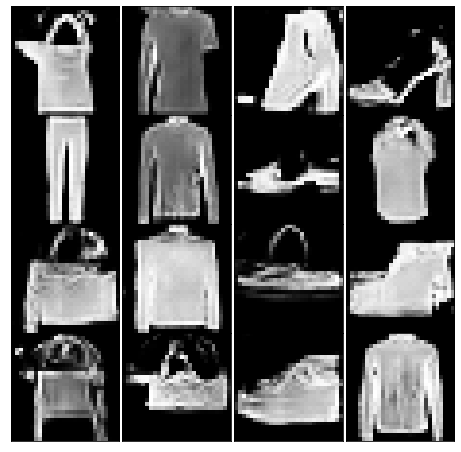

In [21]:
iterations = 20000
batch_size = 128
sample_interval = 5
train(iterations, batch_size, sample_interval)

In [22]:
from keras.models import model_from_json
from keras.models import load_model

In [24]:
model_dcgan_mnist = gan.to_json()
with open("model_dcgn_fashionmnist_num.json", "w") as json_file:
    json_file.write(model_dcgan_mnist)
gan.save_weights("model_dcgn_fashionmnist_num.h5")


In [25]:
model_generator_mnist = generator.to_json()
with open("model_generator_fashionmnist_num.json", "w") as json_file:
    json_file.write(model_generator_mnist)
generator.save_weights("model_generator_fashionmnist_num.h5")

In [26]:
model_discriminator_mnist = discriminator.to_json()
with open("model_discriminator_fashionmnist_num.json", "w") as json_file:
    json_file.write(model_discriminator_mnist)
discriminator.save_weights("model_discriminator_fashionmnist_num.json.h5")